In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error
from pmdarima.arima import auto_arima
# %matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tfa

import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
data = pd.read_excel('Natural_Gas_Spot_Price.xlsx')

In [3]:
data = data.rename(
    columns={
        "Henry Hub Natural Gas Spot Price (Dollars per Million Btu)":"gas_price",
        "Date":"date"
    }
)

data = data.fillna(method = 'pad')
print(data.isnull().sum())
data['date'] = pd.to_datetime(data['date'], format = "%d/%m/%Y")
data = data.set_index('date')

date         0
gas_price    0
dtype: int64


In [4]:
data

,gas_price
date,
1997-01-07,3.82
1997-01-08,3.80
1997-01-09,3.61
1997-01-10,3.92
1997-01-13,4.00
...,...
2022-11-09,3.46
2022-11-10,4.80
2022-11-11,4.80


In [5]:
data = data.sort_values(by = 'date')

train = data['1997-01-06': '2015-03-12'] # 7 Jan 1997 to 6 Jan 2021 
test = data['2015-03-13': '2022-11-15']

In [6]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [7]:
df3 = data['gas_price']

In [8]:
df3

date
1997-01-07    3.82
1997-01-08    3.80
1997-01-09    3.61
1997-01-10    3.92
1997-01-13    4.00
              ... 
2022-11-09    3.46
2022-11-10    4.80
2022-11-11    4.80
2022-11-14    6.24
2022-11-15    5.90
Name: gas_price, Length: 6505, dtype: float64

In [9]:
# load dataset
series = df3
# seasonal difference
X = series.values
days = 79
differenced = difference(X, days)
# fit model
# model = sm.tsa.arima.ARIMA(series, order=(3, 0, 2))
model = SARIMAX(differenced,
                order=(3,1,2), 
                seasonal_order=(0, 0, 0, 12))
model_fit = model.fit()
# multi-step out-of-sample forecast
start_index = len(differenced)
end_index = start_index + 100
forecast = model_fit.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
# print(forecast)
history = [x for x in X]
day = 1
inverted_list = []
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days)
	inverted_list.append(inverted)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Day 1: 6.617307
Day 2: 6.015371
Day 3: 6.047057
Day 4: 5.656374
Day 5: 5.524990
Day 6: 5.337710
Day 7: 5.139286
Day 8: 5.729962
Day 9: 5.630534
Day 10: 5.090826
Day 11: 5.201020
Day 12: 5.191135
Day 13: 5.861206
Day 14: 6.061249
Day 15: 5.951276
Day 16: 6.611292
Day 17: 6.841302
Day 18: 6.751308
Day 19: 6.471312
Day 20: 7.181314
Day 21: 7.081315
Day 22: 6.601316
Day 23: 6.801317
Day 24: 6.811317
Day 25: 6.571317
Day 26: 6.431317
Day 27: 6.261317
Day 28: 6.711317
Day 29: 6.511317
Day 30: 5.851317
Day 31: 5.451317
Day 32: 5.601317
Day 33: 5.641317
Day 34: 5.531317
Day 35: 5.821317
Day 36: 6.031317
Day 37: 5.931317
Day 38: 5.441317
Day 39: 5.291317
Day 40: 5.341317
Day 41: 5.321317
Day 42: 5.091317
Day 43: 4.081317
Day 44: 4.081317
Day 45: 4.161317
Day 46: 3.921317
Day 47: 3.901317
Day 48: 3.731317
Day 49: 2.971317
Day 50: 2.731317
Day 51: 3.171317
Day 52: 4.241317
Day 53: 3.581317
Day 54: 3.531317
Day 55: 3.931317
Day 56: 3.581317
Day 57: 3.431317
Day 58: 3.411317
Day 59: 3.491317
Day 60

In [10]:
sarima_model = SARIMAX(data, order=(3,1,2))
result = sarima_model.fit()

In [11]:
dates = pd.date_range(start='2022-11-16', periods=100, freq='D')

In [12]:
dates = pd.DataFrame(dates)
dates

,0
0,2022-11-16
1,2022-11-17
2,2022-11-18
3,2022-11-19
4,2022-11-20
...,...
95,2023-02-19
96,2023-02-20
97,2023-02-21
98,2023-02-22


In [13]:
df1 = pd.DataFrame(inverted_list)
df1

,0
0,6.617307
1,6.015371
2,6.047057
3,5.656374
4,5.524990
...,...
96,4.082625
97,3.802629
98,4.512631
99,4.412632


In [14]:
dates['predicted_mean'] = df1
# dates = dates.rename(columns={'0': 'date'})
dates.columns.values[0] = 'date'
dates


,date,predicted_mean
0,2022-11-16,6.617307
1,2022-11-17,6.015371
2,2022-11-18,6.047057
3,2022-11-19,5.656374
4,2022-11-20,5.524990
...,...,...
95,2023-02-19,4.172619
96,2023-02-20,4.082625
97,2023-02-21,3.802629
98,2023-02-22,4.512631


In [15]:
data1 = pd.read_csv('forecast.csv')

data1 = data1.drop('predicted_mean', axis=1)

In [16]:
data1['date'].astype('datetime64[ns]')
dates['date'].astype('datetime64[ns]')

0    2022-11-16
1    2022-11-17
2    2022-11-18
3    2022-11-19
4    2022-11-20
        ...    
95   2023-02-19
96   2023-02-20
97   2023-02-21
98   2023-02-22
99   2023-02-23
Name: date, Length: 100, dtype: datetime64[ns]

In [17]:
dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            100 non-null    datetime64[ns]
 1   predicted_mean  100 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 KB


In [18]:
data1['date'].astype('datetime64[ns]')


0    2022-11-16
1    2022-11-17
2    2022-11-18
3    2022-11-21
4    2022-11-22
        ...    
61   2023-02-15
62   2023-02-16
63   2023-02-17
64   2023-02-21
65   2023-02-22
Name: date, Length: 66, dtype: datetime64[ns]

In [19]:
data1

,date,gas_price
0,2022-11-16,5.88
1,2022-11-17,6.20
2,2022-11-18,6.10
3,2022-11-21,6.23
4,2022-11-22,6.27
...,...,...
61,2023-02-15,2.45
62,2023-02-16,2.48
63,2023-02-17,2.28
64,2023-02-21,2.12


In [20]:
dates

,date,predicted_mean
0,2022-11-16,6.617307
1,2022-11-17,6.015371
2,2022-11-18,6.047057
3,2022-11-19,5.656374
4,2022-11-20,5.524990
...,...,...
95,2023-02-19,4.172619
96,2023-02-20,4.082625
97,2023-02-21,3.802629
98,2023-02-22,4.512631


In [21]:
dates['date'] = pd.to_datetime(dates['date'])
data1['date'] = pd.to_datetime(data1['date'])

In [22]:
df_merged = pd.merge(data1, dates[['date', 'predicted_mean']], on='date', how='inner')

In [23]:
df_merged

,date,gas_price,predicted_mean
0,2022-11-16,5.88,6.617307
1,2022-11-17,6.20,6.015371
2,2022-11-18,6.10,6.047057
3,2022-11-21,6.23,5.337710
4,2022-11-22,6.27,5.139286
...,...,...,...
61,2023-02-15,2.45,3.192523
62,2023-02-16,2.48,3.392567
63,2023-02-17,2.28,3.282593
64,2023-02-21,2.12,3.802629


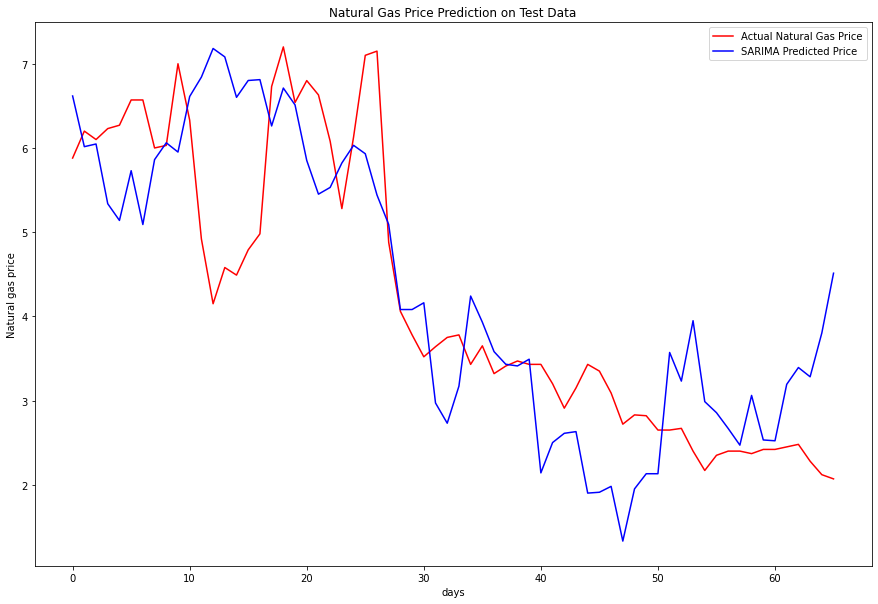

In [24]:
# import matplotlib.dates as mdates

plt.figure(figsize = (15, 10))
# plt.plot(train,color = 'black',label = "train")
plt.plot(df_merged['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(df_merged['predicted_mean'], color = 'blue', label = 'SARIMA Predicted Price')
plt.title("Natural Gas Price Prediction on Test Data")
plt.xlabel('days')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [25]:
mean_squared_error(df_merged['gas_price'], df_merged['predicted_mean'])

1.1580992216026456

In [26]:
yp_train = result.predict(start = 0, end = (len(train)-1))
yp_test = result.predict(start='2020-01-07', end='2022-11-15') 

a = pd.DataFrame(yp_train)
a.rename(columns = {0: 'SARIMA_pred'}, inplace = True)

# a.index = train.iloc[slot:].index
train_compare = pd.concat([train, a], 1)
# print(train_compare)
b = pd.DataFrame(yp_test)
a.rename(columns = {0: 'SARIMA_pred'}, inplace = True)

# a.index = train.iloc[slot:].index
test_compare = pd.concat([test, b], 1)
# print(test_compare)

final = pd.concat([train_compare, test_compare,data1])
final

,gas_price,predicted_mean,date
1997-01-07 00:00:00,3.82,0.000000,NaT
1997-01-08 00:00:00,3.80,3.820000,NaT
1997-01-09 00:00:00,3.61,3.801485,NaT
1997-01-10 00:00:00,3.92,3.631626,NaT
1997-01-13 00:00:00,4.00,3.933141,NaT
...,...,...,...
61,2.45,NaN,2023-02-15
62,2.48,NaN,2023-02-16
63,2.28,NaN,2023-02-17
64,2.12,NaN,2023-02-21
